# Home Credit Default Risk

## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve] as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

- `application_train_aai.csv`: Training dataset to train and find the best hyperparameters on the model.

- `application_test_aai.csv`: Test dataset without labels.

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

In [7]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis


#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [ ]:
train_data= pd.read_csv('./dataset/application_train_aai.csv')
test_data= pd.read_csv('./dataset/application_test_aai.csv')

print(f'Number of training samples: {train_data.shape[0]}')
print(f'Number of testing samples: {test_data.shape[0]}')

1.3. List all columns in the train dataset.

In [9]:
train_columns = train_data.columns
print('Columns in the training dataset:\n')
for col in train_columns:
    print(col)

Columns in the training dataset:

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPAR

1.4. Show the first 5 records of the training dataset

In [10]:
transposed_data = train_data.head(5).transpose()
print(transposed_data)

                                     0           1                2  \
SK_ID_CURR                      428247      140966           407283   
TARGET                               0           0                0   
NAME_CONTRACT_TYPE          Cash loans  Cash loans  Revolving loans   
CODE_GENDER                          F           M                F   
FLAG_OWN_CAR                         N           Y                N   
...                                ...         ...              ...   
AMT_REQ_CREDIT_BUREAU_DAY          NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_WEEK         NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_MON          NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_QRT          NaN         0.0              0.0   
AMT_REQ_CREDIT_BUREAU_YEAR         NaN         0.0              0.0   

                                     3           4  
SK_ID_CURR                      434300      446788  
TARGET                               0   

1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Total Value Counts:
0    226257
1     19751
Name: TARGET, dtype: int64
Percentage of Each Value:
Paid (0): 91.97%
Not Paid (1): 8.03%"


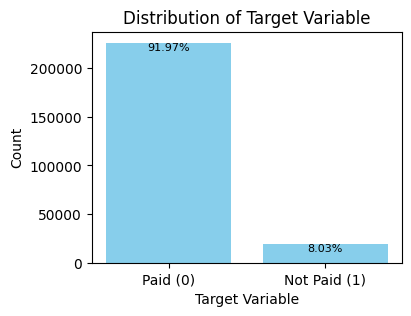

In [11]:
target_count = train_data['TARGET'].value_counts()

percentages = (target_count / len(train_data)) * 100

print(f'''Total Value Counts:
{target_count}
Percentage of Each Value:
Paid (0): {percentages[0]:.2f}%
Not Paid (1): {percentages[1]:.2f}%"''')

plt.figure(figsize=(4,3))
bars = plt.bar(target_count.index, target_count.values, color='skyblue')
plt.title('Distribution of Target Variable')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(target_count.index, ['Paid (0)', 'Not Paid (1)'])
for bar, percentage in zip(bars, percentages):
    plt.annotate(f'{percentage:.2f}%', (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha='center', va='top', fontsize=8)
plt.show()


1.6. Show the number of columns of each data type.

In [12]:
columnn_data_types = train_data.dtypes.value_counts()
print(f'The number of columns for each data type is: \n{columnn_data_types}')

The number of columns for each data type is: 
float64    65
int64      41
object     16
dtype: int64


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

In [13]:
### TODO Complete in this cell: show number of unique values per categorical column
categorical_columns = train_data.select_dtypes(include=['object']).columns
distinct_value_counts = {col: train_data[col].nunique() for col in categorical_columns}
distinct_value_counts_df = pd.DataFrame.from_dict(distinct_value_counts, orient='index', columns=['Distinct Values'])
print(f'Number of distinct values for each categorical column:\n{distinct_value_counts_df}')

Number of distinct values for each categorical column:
                            Distinct Values
NAME_CONTRACT_TYPE                        2
CODE_GENDER                               3
FLAG_OWN_CAR                              2
FLAG_OWN_REALTY                           2
NAME_TYPE_SUITE                           7
NAME_INCOME_TYPE                          8
NAME_EDUCATION_TYPE                       5
NAME_FAMILY_STATUS                        6
NAME_HOUSING_TYPE                         6
OCCUPATION_TYPE                          18
WEEKDAY_APPR_PROCESS_START                7
ORGANIZATION_TYPE                        58
FONDKAPREMONT_MODE                        4
HOUSETYPE_MODE                            3
WALLSMATERIAL_MODE                        7
EMERGENCYSTATE_MODE                       2


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

In [14]:
### TODO Complete in this cell: checking missing data
missing_data = train_data.isnull().sum()
missing_percentage = (missing_data/len(train_data) * 100).round(2)
missiing_data_df = pd.DataFrame({'Column':missing_data.index,
                                 'Total data missing':missing_data.values, 
                                 'Missing percentage': missing_percentage.values})
missiing_data_df = missiing_data_df.sort_values(by = ['Missing percentage'], ascending = False)
top_missing_columns = missiing_data_df.head(20)

print(f'Top 20 columns with missing data: \n{top_missing_columns}')


Top 20 columns with missing data: 
                      Column  Total data missing  Missing percentage
76           COMMONAREA_MEDI              172189               69.99
48            COMMONAREA_AVG              172189               69.99
62           COMMONAREA_MODE              172189               69.99
70  NONLIVINGAPARTMENTS_MODE              171096               69.55
56   NONLIVINGAPARTMENTS_AVG              171096               69.55
84  NONLIVINGAPARTMENTS_MEDI              171096               69.55
86        FONDKAPREMONT_MODE              168561               68.52
68     LIVINGAPARTMENTS_MODE              168494               68.49
54      LIVINGAPARTMENTS_AVG              168494               68.49
82     LIVINGAPARTMENTS_MEDI              168494               68.49
52             FLOORSMIN_AVG              167255               67.99
66            FLOORSMIN_MODE              167255               67.99
80            FLOORSMIN_MEDI              167255               67.99

#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

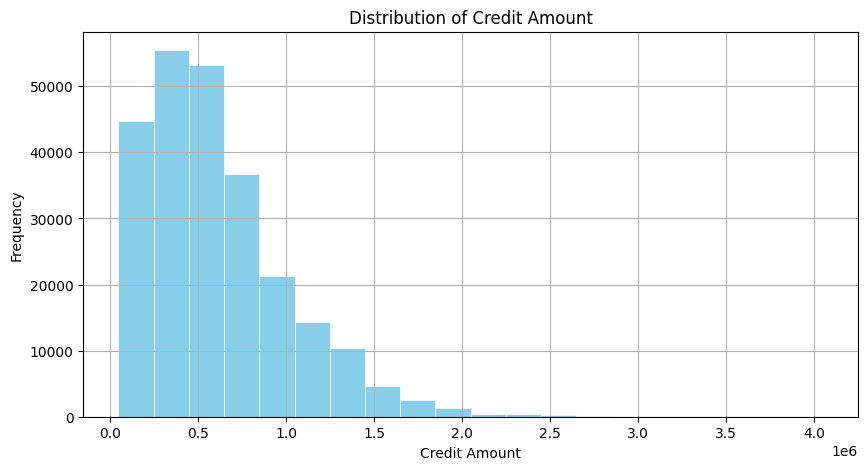

In [15]:
import matplotlib.pyplot as plt
credit_amount = train_data['AMT_CREDIT']
plt.figure(figsize=(10,5))
plt.hist(credit_amount, bins=20, edgecolor='white', linewidth=0.5, color='skyblue')
plt.xlabel('Credit Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Credit Amount')
plt.grid(True)
plt.show()

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

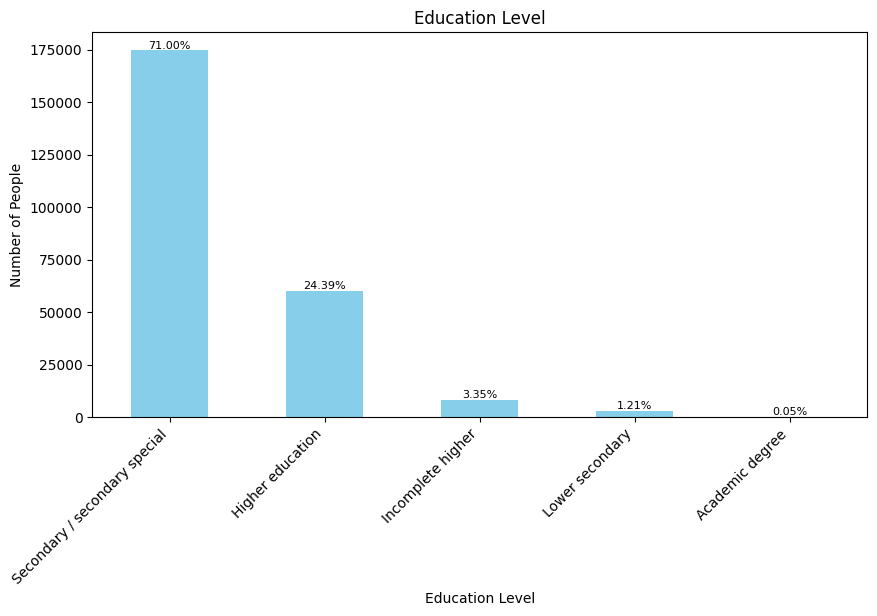

In [16]:
import matplotlib.pyplot as plt
education_level = train_data['NAME_EDUCATION_TYPE']
education_count = education_level.value_counts()
education_percentage = education_count / education_count.sum() * 100

plt.figure(figsize=(10, 5))
education_count.plot(kind='bar', color='skyblue', linewidth = 0.5)
plt.title('Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of People')
plt.xticks(rotation=45, ha='right')

for i, percentage in enumerate(education_percentage):
    plt.text(i, education_count[i], f'{percentage:.2f}%', ha='center', va='bottom', fontsize = 8)

plt.show()

1.11. Plot the distribution of ocupation of the loan applicants.

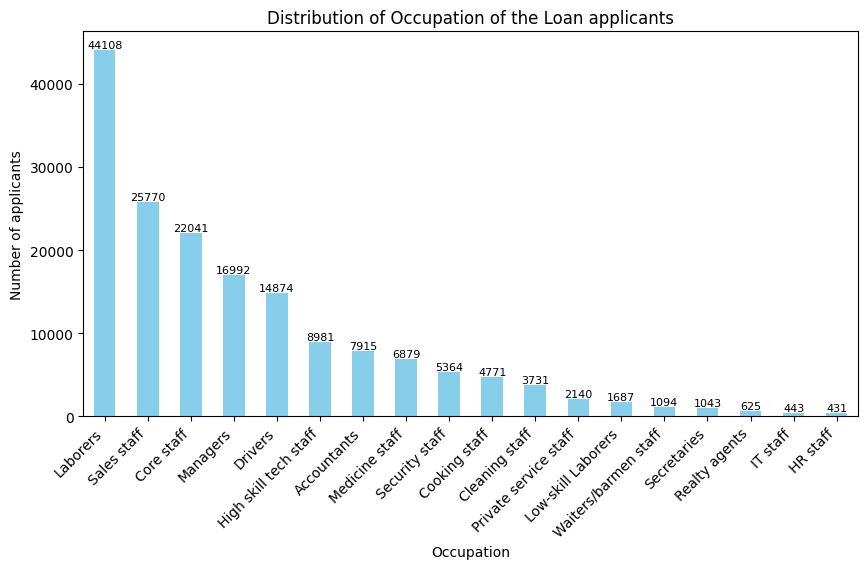

In [17]:
### TODO Complete in this cell: ocupation of applicants
occupation_type = train_data['OCCUPATION_TYPE']
occupation_count = train_data['OCCUPATION_TYPE'].value_counts()

plt.figure(figsize=(10,5))
ax = occupation_count.plot(kind='bar', color='skyblue')
plt.title('Distribution of Occupation of the Loan applicants')
plt.xlabel('Occupation')
plt.ylabel('Number of applicants')
plt.xticks(rotation=45, ha= 'right')

for i, count in enumerate(occupation_count):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize = 8)

plt.show()

1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

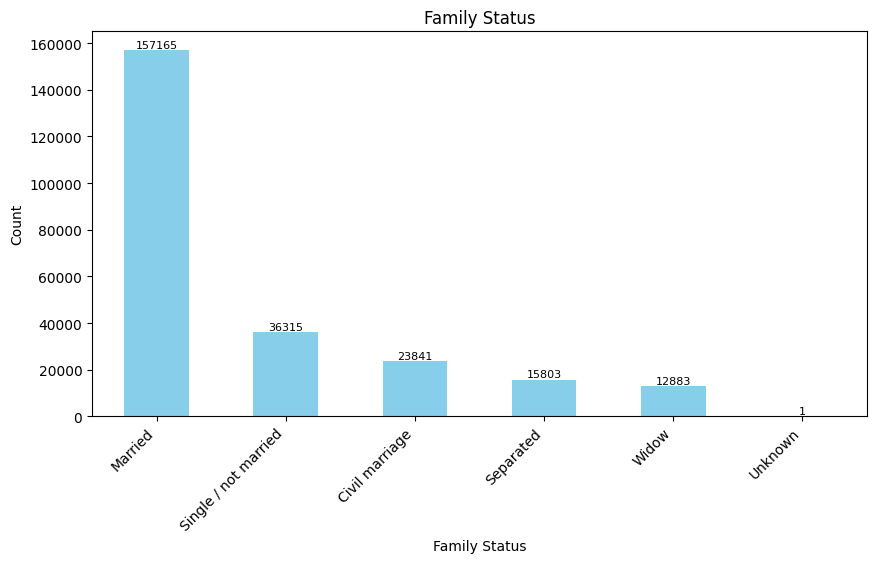

In [18]:
### TODO Complete in this cell: family status
family_status = train_data['NAME_FAMILY_STATUS']
family_status_count = family_status.value_counts()

plt.figure(figsize=(10,5))
ax = family_status_count.plot(kind='bar', color = 'skyblue')
plt.title('Family Status')
plt.xlabel('Family Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

for i, count in enumerate(family_status_count):
    ax.text(i, count, str(count), ha='center', va='bottom', fontsize = 8)
    
plt.show()


1.13. Plot the income type of applicants grouped by the target variable.

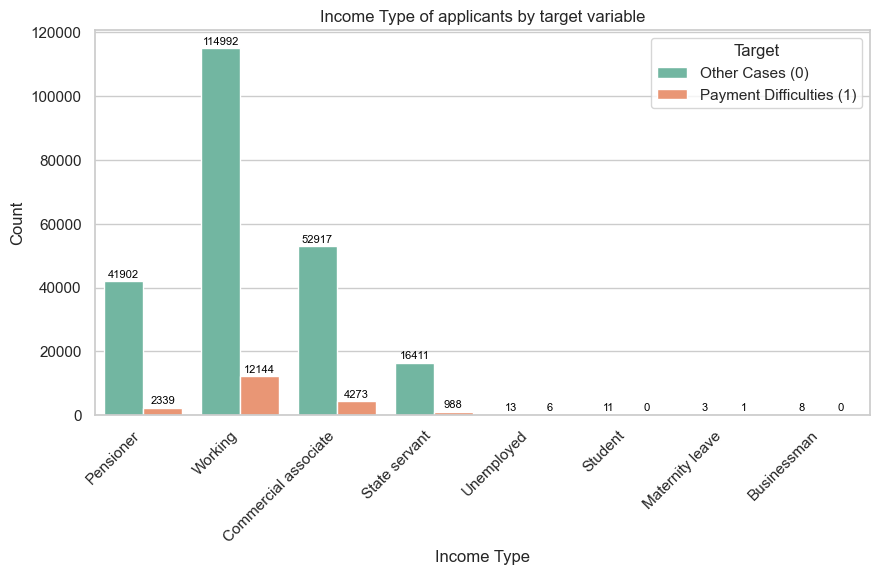

In [19]:
sns.set(style = 'whitegrid')

plt.figure(figsize = (10,5))
ax = sns.countplot(data = train_data, x = 'NAME_INCOME_TYPE', hue = 'TARGET', palette = 'Set2')
plt.title('Income Type of applicants by target variable')
plt.xlabel('Income Type')
plt.ylabel('Count')
plt.xticks(rotation = 45, ha = 'right')
plt.legend(title = 'Target', labels = ['Other Cases (0)', 'Payment Difficulties (1)'])

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', fontsize=8, color='black', xytext = (0, 5),
                textcoords = 'offset points')
    
plt.show()


## 2. Preprocessing

In [20]:
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


In [21]:
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

Success: X_train shape is correct!
Success: X_train type is correct!
Success: y_train shape is correct!
Success: X_test shape is correct!
Success: X_test type is correct!
Success: y_test shape is correct!


In [22]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Input train data shape:  (196806, 121)
Input val data shape:  (49202, 121)
Input test data shape:  (61503, 121) 



c:\Users\camil\Desktop\Python\Anyone AI\SPRINT 2\assignment\assignment\sprint2\Lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Success: train_data shape is correct!
Success: train_data type is correct!
Success: val_data shape is correct!
Success: val_data type is correct!
Success: test_data shape is correct!
Success: test_data type is correct!


## 3. Training Models

### Baseline: LogisticRegression

In [23]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

CPU times: total: 9.11 s
Wall time: 2.98 s


LogisticRegression(C=0.0001)

In [24]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

Success: Logistic regression model type is correct!


In [25]:
# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

In [26]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.6798
Validation ROC AUC Score: 0.6772


Based on the AUC ROC scores, it doesn’t appear that there is overfitting. This is typically observed when the model performs significantly better on the training data than on the validation data. In this case, both scores are relatively close, which would suggest that there is no overfitting.
As for underfitting, although the score is not particularly high, it doesn’t necessarily indicate underfitting.

In [27]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

Success: AUC ROC score type is correct!
Success: AUC ROC score is correct!


### Training a Random Forest Classifier 

In [28]:
%%time
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(train_data, y_train)

CPU times: total: 4min 43s
Wall time: 42.4 s


RandomForestClassifier(n_jobs=-1)

In [29]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

Success: RandomForestClassifier model type is correct!


In [30]:
# Train data predictions (class 1)
rf_pred_train = rf.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_pred_val = rf.predict_proba(val_data)[:, 1]

In [31]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 1.0000
Validation ROC AUC Score: 0.7055


A ROC AUC score of 1 on the training data indicates a perfect fit of the model to the training data, suggesting that the model has memorized the training data and may be overfitting. On the other hand, a ROC AUC score of 0.7071 on the validation data suggests that the model's performance on unseen data is lower, which could be an indication of overfitting 

### Randomized Search with Cross Validation

In [33]:
%%time
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [400,600],
    'max_depth': [5,15],
    'min_samples_split': [5,15,20],
    'min_samples_leaf': [20,30,40],
    'max_features': ['sqrt'],
    'criterion': ['gini'],
    'bootstrap': [True]
    }
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=30, scoring='roc_auc',
                               cv=5, verbose=2, random_state=42)
rf_random.fit(train_data, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=40, min_samples_split=20, n_estimators=600; total time= 2.7min
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=40, min_samples_split=20, n_estimators=600; total time= 2.4min
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=40, min_samples_split=20, n_estimators=600; total time= 2.4min
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=40, min_samples_split=20, n_estimators=600; total time= 2.3min
[CV] END bootstrap=True, criterion=gini, max_depth=15, max_features=sqrt, min_samples_leaf=40, min_samples_split=20, n_estimators=600; total time= 2.4min
[CV] END bootstrap=True, criterion=gini, max_depth=5, max_features=sqrt, min_samples_leaf=40, min_samples_split=5, n_estimators=600; total time= 1.3min
[CV] END bootstr

In [44]:
best_params = rf_random.best_params_
best_rf_model = RandomForestClassifier(random_state=42, **best_params, n_jobs=-1)
best_rf_model.fit(train_data, y_train)
# Train data predictions (class 1)
rf_tuned_pred_train = best_rf_model.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
rf_tuned_pred_val = best_rf_model.predict_proba(val_data)[:, 1]

In [45]:
# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=rf_tuned_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=rf_tuned_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

Train ROC AUC Score: 0.8533
Validation ROC AUC Score: 0.7400


In [46]:
%%time

test_preds = best_rf_model.predict_proba(test_data)[:, 1]
app_test["TARGET"] = test_preds
app_test.to_csv(config.DATASET_TEST, index=False)

CPU times: total: 29.6 s
Wall time: 16.3 s


Training a LightGBM model 

In [56]:
### Complete in this cell: train a LightGBM model
import lightgbm as lgb

# Define the parameter grid
param_grid = {
    'objective': ['binary'],
    'metric': ['auc'],
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [10, 60, 120],
    'max_depth': [4, 6, 7],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [300, 600, 1000],
}

# Create a LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Fit the model to find the best parameters
random_search.fit(train_data, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Create the best LightGBM model with the best parameters
best_lgb_model = lgb.LGBMClassifier(random_state=42, **best_params)

# Fit the best model on the training data
best_lgb_model.fit(train_data, y_train)
print(random_search.best_params_)


[LightGBM] [Info] Number of positive: 15784, number of negative: 181022
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11604
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080201 -> initscore=-2.439622
[LightGBM] [Info] Start training from score -2.439622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

LGBMClassifier(max_depth=4, metric='auc', n_estimators=300, num_leaves=120,
               objective='binary', random_state=42)

In [57]:
lgb_pred_train = best_lgb_model.predict_proba(train_data)[:, 1]

lgb_pred_val = best_lgb_model.predict_proba(val_data)[:, 1]

roc_auc_train_lgb = roc_auc_score(y_true=y_train, y_score=lgb_pred_train)
print(f"Train ROC AUC Score: {roc_auc_train_lgb:.4f}")


roc_auc_val_lgb = roc_auc_score(y_true=y_val, y_score=lgb_pred_val)
print(f"Validation ROC AUC Score: {roc_auc_val_lgb:.4f}")

Train ROC AUC Score: 0.8060
Validation ROC AUC Score: 0.7547
